<a href="https://colab.research.google.com/github/vig202204/A-B-Test_Python_BigQuery_Tableau/blob/main/Portfolio_project_2_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Мета проекту

- проаналізувати результати A/B-тестування за допомогою статистичних методів в Python та створити візуалізацію, що демонструє ключові конверсійні метрики.


### Виконуємо імпорт необхідних бібліотек для виконання подальших кроків цього завдання:

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connection to sources
from google.colab import auth
from google.cloud import bigquery
from google.colab import drive

### Під'єднаємось до джерела даних

In [84]:
# Singn In to DB
auth.authenticate_user()

client = bigquery.Client(project="data-analytics-mate")


### Імпортуємо ісходні дані

In [85]:
# Create query for source dataset
query_project = """
# AB Testing tool - SQL for analysis

/*
date,
country,
device,
continent,
chanel,
test,
test_group,
event_name, - session with orders - event name - session - new accounts
value
*/

WITH
session_info AS (
  SELECT
        s.date,
        s.ga_session_id,
        sp.country,
        sp.device,
        sp.continent,
        sp.channel,
        ab.test,
        ab.test_group
  FROM `DA.ab_test` ab
  JOIN `DA.session` s ON ab.ga_session_id = s.ga_session_id
  JOIN `DA.session_params` sp ON ab.ga_session_id = sp.ga_session_id
),
session_with_order AS(
  SELECT
          si.date,
          si.country,
          si.device,
          si.continent,
          si.channel,
          si.test,
          si.test_group,
          COUNT(DISTINCT o.ga_session_id) AS session_with_orders
  FROM `DA.order` o
  JOIN session_info si ON o.ga_session_id = si.ga_session_id
  GROUP BY
          si.date,
          si.country,
          si.device,
          si.continent,
          si.channel,
          si.test,
          si.test_group
),
events AS(
  SELECT
        si.date,
        si.country,
        si.device,
        si.continent,
        si.channel,
        si.test,
        si.test_group,
        ep.event_name,
        COUNT(ep.ga_session_id) AS event_cnt
  FROM `DA.event_params` ep
  JOIN session_info si ON ep.ga_session_id = si.ga_session_id
  GROUP BY
        si.date,
        si.country,
        si.device,
        si.continent,
        si.channel,
        si.test,
        si.test_group,
        ep.event_name
),
session AS(
  SELECT
        si.date,
        si.country,
        si.device,
        si.continent,
        si.channel,
        si.test,
        si.test_group,
        COUNT(DISTINCT si.ga_session_id) AS session_cnt

  FROM session_info si
  GROUP BY
          si.date,
          si.country,
          si.device,
          si.continent,
          si.channel,
          si.test,
          si.test_group
),
account AS (
  SELECT
          si.date,
          si.country,
          si.device,
          si.continent,
          si.channel,
          si.test,
          si.test_group,
          COUNT(DISTINCT acs.ga_session_id) AS new_account_cnt

  FROM `DA.account_session` acs
  JOIN session_info si ON si.ga_session_id = acs.ga_session_id
  GROUP BY
          si.date,
          si.country,
          si.device,
          si.continent,
          si.channel,
          si.test,
          si.test_group
)
SELECT
      swo.date,
      swo.country,
      swo.device,
      swo.continent,
      swo.channel,
      swo.test,
      swo.test_group,
      'session_with_orders' AS event_name,
      swo.session_with_orders AS value
FROM session_with_order swo

UNION ALL

SELECT
      e.date,
      e.country,
      e.device,
      e.continent,
      e.channel,
      e.test,
      e.test_group,
      e.event_name,
      e.event_cnt AS value
FROM events e

UNION ALL

SELECT
      s.date,
      s.country,
      s.device,
      s.continent,
      s.channel,
      s.test,
      s.test_group,
      'session' AS event_name,
      s.session_cnt AS value
FROM session s

UNION ALL

SELECT
      a.date,
      a.country,
      a.device,
      a.continent,
      a.channel,
      a.test,
      a.test_group,
      'new account' AS event_name,
      a.new_account_cnt AS value
FROM account a
"""


In [86]:
# Create DF
try:
    # Run the query
    query_job = client.query(query_project)

    # Get the result as a dataframe
    new_dataset_df = query_job.to_dataframe()
except Exception as e:
    print(f"Помилка при виконанні запиту: {e}")
    print("Будь ласка, перевірте дозволи для вашого облікового запису Google на доступ до таблиць BigQuery в проекті 'data-analytics-mate'.")


#### Візуалізуємо основні характеристики датафрейму `new_dataset_df`:

In [87]:
# Re-running for updated statistics after SQL optimizations and datetime conversion
print("\n1. Displaying first 10 row:\n")
display(new_dataset_df.head(10))

print("\n2. Displaying info of Dataframe:\n")
display(new_dataset_df.info())

print(f"\n3. Displaying descriptive statistics of Dataframe:\n")
display(new_dataset_df.describe())

print(f"\n4. Number of missing values in the columns:\n{new_dataset_df.isna().sum()}")

print(f"\n5. Percentage of missing values in columns:\n{new_dataset_df.isna().sum() / new_dataset_df.shape[0] * 100}")


1. Displaying first 10 row:



,date,country,device,continent,channel,test,test_group,event_name,value
0,2020-11-01,Lithuania,desktop,Europe,Paid Search,2,2,new account,1
1,2020-11-02,Venezuela,mobile,Americas,Organic Search,2,2,new account,1
2,2020-11-03,Cambodia,desktop,Asia,Direct,2,1,new account,1
3,2020-11-03,Malta,desktop,Europe,Direct,2,1,new account,1
4,2020-11-03,Estonia,mobile,Europe,Direct,2,1,new account,1
5,2020-11-05,Mongolia,mobile,Asia,Direct,2,1,new account,1
6,2020-11-08,Lebanon,mobile,Asia,Direct,2,1,new account,1
7,2020-11-10,North Macedonia,mobile,Europe,Organic Search,2,1,new account,1
8,2020-11-10,Belarus,desktop,Europe,Paid Search,2,2,new account,1
9,2020-11-11,Uruguay,desktop,Americas,Organic Search,2,2,new account,1



2. Displaying info of Dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800996 entries, 0 to 800995
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        800996 non-null  dbdate
 1   country     800996 non-null  object
 2   device      800996 non-null  object
 3   continent   800996 non-null  object
 4   channel     800996 non-null  object
 5   test        800996 non-null  Int64 
 6   test_group  800996 non-null  Int64 
 7   event_name  800996 non-null  object
 8   value       800996 non-null  Int64 
dtypes: Int64(3), dbdate(1), object(5)
memory usage: 57.3+ MB


None


3. Displaying descriptive statistics of Dataframe:



,test,test_group,value
count,800996.0,800996.0,800996.0
mean,2.831191,1.499608,9.475863
std,1.11694,0.5,37.493267
min,1.0,1.0,1.0
25%,2.0,1.0,1.0
50%,3.0,1.0,2.0
75%,4.0,2.0,5.0
max,4.0,2.0,1575.0



4. Number of missing values in the columns:
date          0
country       0
device        0
continent     0
channel       0
test          0
test_group    0
event_name    0
value         0
dtype: int64

5. Percentage of missing values in columns:
date          0.0
country       0.0
device        0.0
continent     0.0
channel       0.0
test          0.0
test_group    0.0
event_name    0.0
value         0.0
dtype: float64


#### Перетворимо стовпець з типом дати `dbdate`  на тип datetime.

Для забезпечення повної сумісності з функціоналом Pandas `datetime` та уникнення потенційних проблем, явно перетворимо колонку `date` на тип `datetime64[ns]`.

In [88]:
new_dataset_df['date'] = pd.to_datetime(new_dataset_df['date']).dt.normalize()

print("1.1. Інформація про датафрейм new_dataset_df після явного перетворення order_date:")
display(new_dataset_df.info())
display(new_dataset_df.head())

1.1. Інформація про датафрейм new_dataset_df після явного перетворення order_date:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800996 entries, 0 to 800995
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        800996 non-null  datetime64[ns]
 1   country     800996 non-null  object        
 2   device      800996 non-null  object        
 3   continent   800996 non-null  object        
 4   channel     800996 non-null  object        
 5   test        800996 non-null  Int64         
 6   test_group  800996 non-null  Int64         
 7   event_name  800996 non-null  object        
 8   value       800996 non-null  Int64         
dtypes: Int64(3), datetime64[ns](1), object(5)
memory usage: 57.3+ MB


None

,date,country,device,continent,channel,test,test_group,event_name,value
0,2020-11-01,Lithuania,desktop,Europe,Paid Search,2,2,new account,1
1,2020-11-02,Venezuela,mobile,Americas,Organic Search,2,2,new account,1
2,2020-11-03,Cambodia,desktop,Asia,Direct,2,1,new account,1
3,2020-11-03,Malta,desktop,Europe,Direct,2,1,new account,1
4,2020-11-03,Estonia,mobile,Europe,Direct,2,1,new account,1


## Етап 1. Розрахунок статистичної значущості.

У модулі по A/B-тестуванню  аналіз статистичної чущості проводився за допомогою онлайн-калькуляторів, це не завжди зручно. Тому у цьому проекті першим і найбільшим етапом доопрацюємо розрахунок статистичної значущості через Python скрипт.

Для аналізу використаємо набір даних, з яким працювали для побудови дашборду у проекті `Create Your A/B Testing Tool`;

- Створимо блокнот у Google Collab та порахуємо статистичну значущість для чотирьох метрик:

  - add_payment_info / session
  - add_shipping_info / session
  - begin_checkout / session
  - new_accounts / session

- Розрахуємо значущість в тоталі по тесту.

> Важливо! Ми розглядаємо приклад лише з 4 метрик, але їх може бути набагато більше. Тому розрахунок статистичної значимості зробимо через масиви значень та цикли, без статичного закріплення кількості метрик, та їх значень. Закріплювати статично потрібно лише назви 4 визначених метрик та те як вони рахуються.

- Фінальний файл з результатами має містити всю необхідну інформацію для подальшої візуалізації у Tableau.

#### Створимо копію `new_dataset_df` для подальшого аналізу.


In [89]:
df_ab_test = new_dataset_df.copy()
print("DataFrame 'new_dataset_df' copied to 'df_ab_test'.")

DataFrame 'new_dataset_df' copied to 'df_ab_test'.


#### Підготувати дані шляхом агрегування загальної кількості сесій та подій для кожної метрики та групи тестування ('`test`' та '`test_group`'). Це включає обчислення коефіцієнтів конверсії.


In [90]:
conversion_metrics = [
    'add_payment_info',
    'add_shipping_info',
    'begin_checkout',
    'new account']
grouping_dimension = 'test'

print(f"Conversion metrics defined: {conversion_metrics}")
print(f"Grouping dimension defined: {grouping_dimension}")

Conversion metrics defined: ['add_payment_info', 'add_shipping_info', 'begin_checkout', 'new account']
Grouping dimension defined: test


In [91]:
print("Unique event names in df_ab_test:", df_ab_test['event_name'].unique().tolist())
print("Number of unique event names in df_ab_test:", len(df_ab_test['event_name'].unique().tolist()))

Unique event names in df_ab_test: ['new account', 'session_with_orders', 'session', 'user_engagement', 'page_view', 'scroll', 'view_item', 'session_start', 'view_promotion', 'view_search_results', 'first_visit', 'add_shipping_info', 'add_to_cart', 'begin_checkout', 'select_promotion', 'select_item', 'add_payment_info', 'click', 'view_item_list']
Number of unique event names in df_ab_test: 19


In [92]:
df_agg = df_ab_test[df_ab_test['event_name'].isin(conversion_metrics + ['session'])
                   ].groupby([grouping_dimension, 'test_group', 'event_name'])['value'].sum().unstack(fill_value=0)

print("Aggregated DataFrame created, unstacked, and NaNs filled with 0.")
print("Columns in df_agg after re-creation:", df_agg.columns.tolist())

Aggregated DataFrame created, unstacked, and NaNs filled with 0.
Columns in df_agg after re-creation: ['add_payment_info', 'add_shipping_info', 'begin_checkout', 'new account', 'session']


#### Розрахуємо коефіцієнти конверсії для кожного показника, поділивши кількість подій на кількість сеансів.

In [93]:
df_conversion = df_agg.copy()

for metric in conversion_metrics:
    df_conversion[f'{metric}_conversion'] = df_conversion[metric] / df_conversion['session']

# print("Conversion rates calculated.")
# print("\nFirst 5 rows of the Conversion DataFrame:")
# display(df_conversion.head())
# print("\nInfo of the Conversion DataFrame:")
# display(df_conversion.info())

### Розрахуємо `p-значення` для кожної метрики конверсії між контрольною та тестовою групами.

1. Імпортуємо необхідні функції для статистичного аналізу (наприклад, `ttest_ind` або інші для пропорцій).
2. Створимо порожній список `p_values_data` для зберігання результатів.
3. Для кожної метрики конверсії (наприклад, `add_payment_info_conversion`, `add_shipping_info_conversion` тощо):   
    a) виділимо коефіцієнти конверсії для контрольної (`test_group` = 1) та тестової (`test_group` = 2) груп;   
    b) передамо ці значення у функцію для статистичного тесту (наприклад, `ttest_ind`) разом з відповідними кількостями сесій для розрахунку;   
    c) збережемо назву метрики та обчислене p-значення у `p_values_data`.
4. Перетворимо `p_values_data` на DataFrame.

Щоб обчислити `p-значення` для порівняння пропорцій (коефіцієнтів конверсії) між двома групами, використаємо статистичний тест, відповідний для пропорцій. Для цього підходить функція `proportions_ztest` з `statsmodels.stats.proportion`.

Розрахуємо `p-значення` для кожної метрики конверсії між контрольною та тестовою групами для кожного значення параметра `test` та збережемо результати в DataFrame `df_p_values_by_test`.


In [94]:
from statsmodels.stats.proportion import proportions_ztest

p_values_data_all_tests = []

unique_tests = df_conversion.index.get_level_values(grouping_dimension).unique()

for current_test_value in unique_tests:
    # Filter data for the current 'test' value
    df_current_test = df_conversion.loc[current_test_value]

    for metric in conversion_metrics:
        metric_conversion_col = f'{metric}_conversion'

        # Get counts for control and test groups within the current 'test' value
        control_events = df_current_test.loc[1, metric]
        control_sessions = df_current_test.loc[1, 'session']
        test_events = df_current_test.loc[2, metric]
        test_sessions = df_current_test.loc[2, 'session']

        # Perform z-test for proportions
        stat, p_value = proportions_ztest(
            count=[control_events, test_events],
            nobs=[control_sessions, test_sessions]
        )

        # Calculate percentage change
        control_conv_rate = df_current_test.loc[1, metric_conversion_col]
        test_conv_rate = df_current_test.loc[2, metric_conversion_col]
        metric_change = ((test_conv_rate - control_conv_rate) / control_conv_rate) * 100

        p_values_data_all_tests.append({
            'test_number': current_test_value,
            'metric': metric,
            'numerator_event': metric,
            'denominator_event': 'session',
            'numerator_count_test_events': test_events,
            'denominator_count_test_sessions': test_sessions,
            'conversion_rate_test': test_conv_rate,
            'numerator_control_events': control_events,
            'denominator_control_sessions': control_sessions,
            'conversion_rate_control': control_conv_rate,
            'metric_change': metric_change,
            'z_stat': abs(stat),
            'p_value': p_value,

            # 'test_value': current_test_value,
            # 'control_conversion': control_conv_rate,
            # 'test_conversion': test_conv_rate,
            # 'control_events': control_events,
            # 'control_sessions': control_sessions,
            # 'test_events': test_events,
            # 'test_sessions': test_sessions
        })

df_p_values_by_test = pd.DataFrame(p_values_data_all_tests)

print("P-values calculated for each 'test' value and stored in df_p_values_by_test.")
print("\nP-values DataFrame by Test:")
# display(df_p_values_by_test)
display(df_p_values_by_test[df_p_values_by_test['test_number'] == 2])

P-values calculated for each 'test' value and stored in df_p_values_by_test.

P-values DataFrame by Test:


,test_number,metric,numerator_event,denominator_event,numerator_count_test_events,denominator_count_test_sessions,conversion_rate_test,numerator_control_events,denominator_control_sessions,conversion_rate_control,metric_change,z_stat,p_value
4,2,add_payment_info,add_payment_info,session,2409,50244,0.047946,2344,50637,0.046290,3.576911,1.240994,0.214608
5,2,add_shipping_info,add_shipping_info,session,3510,50244,0.069859,3480,50637,0.068724,1.650995,0.709557,0.477979
6,2,begin_checkout,begin_checkout,session,4313,50244,0.085841,4262,50637,0.084168,1.988164,0.952898,0.340642
7,2,new account,new account,session,4184,50244,0.083274,4165,50637,0.082252,1.241934,0.588793,0.556000


Об'єднаємо розраховані коефіцієнти конверсії, p-значення та статус значущості в один підсумковий DataFrame для зручного перегляду та подальшої візуалізації.


In [95]:
final_results_df = df_p_values_by_test.copy()

alpha = 0.05
final_results_df['is_significant'] = final_results_df['p_value'].apply(lambda x: 'TRUE' if x < alpha else 'FALSE')

print("Consolidated DataFrame created with significance status.")
print("\nFirst 5 rows of the Final Results DataFrame:")
display(final_results_df.head(16))
print("\nInfo of the Final Results DataFrame:")
display(final_results_df.info())

Consolidated DataFrame created with significance status.

First 5 rows of the Final Results DataFrame:


,test_number,metric,numerator_event,denominator_event,numerator_count_test_events,denominator_count_test_sessions,conversion_rate_test,numerator_control_events,denominator_control_sessions,conversion_rate_control,metric_change,z_stat,p_value,is_significant
0,1,add_payment_info,add_payment_info,session,2229,45193,0.049322,1988,45362,0.043825,12.542021,3.924884,0.000087,TRUE
1,1,add_shipping_info,add_shipping_info,session,3221,45193,0.071272,3034,45362,0.066884,6.560481,2.603571,0.009226,TRUE
2,1,begin_checkout,begin_checkout,session,4021,45193,0.088974,3784,45362,0.083418,6.660587,2.978783,0.002894,TRUE
3,1,new account,new account,session,3681,45193,0.081451,3823,45362,0.084278,-3.354299,1.542883,0.122859,FALSE
4,2,add_payment_info,add_payment_info,session,2409,50244,0.047946,2344,50637,0.046290,3.576911,1.240994,0.214608,FALSE
5,2,add_shipping_info,add_shipping_info,session,3510,50244,0.069859,3480,50637,0.068724,1.650995,0.709557,0.477979,FALSE
6,2,begin_checkout,begin_checkout,session,4313,50244,0.085841,4262,50637,0.084168,1.988164,0.952898,0.340642,FALSE
7,2,new account,new account,session,4184,50244,0.083274,4165,50637,0.082252,1.241934,0.588793,0.556000,FALSE
8,3,add_payment_info,add_payment_info,session,3697,70439,0.052485,3623,70047,0.051722,1.474630,0.643172,0.520112,FALSE
9,3,add_shipping_info,add_shipping_info,session,5188,70439,0.073652,5298,70047,0.075635,-2.621211,1.413727,0.157442,FALSE



Info of the Final Results DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   test_number                      16 non-null     int64  
 1   metric                           16 non-null     object 
 2   numerator_event                  16 non-null     object 
 3   denominator_event                16 non-null     object 
 4   numerator_count_test_events      16 non-null     int64  
 5   denominator_count_test_sessions  16 non-null     int64  
 6   conversion_rate_test             16 non-null     float64
 7   numerator_control_events         16 non-null     int64  
 8   denominator_control_sessions     16 non-null     int64  
 9   conversion_rate_control          16 non-null     float64
 10  metric_change                    16 non-null     float64
 11  z_stat                           16 non-null    

None

### Представимо зведені результати та опишемо ключові висновки щодо статистичної значущості для визначених метрик.


**Короткий зміст:**

**Ключові результати аналізу даних**
  - **Метрики конверсії та групування**:

    Було визначено чотири метрики конверсії (
      - `add_payment_info`,  
      - `add_shipping_info`,  
      - `begin_checkout`,  
      - new `account`),  
    а аналіз було згруповано за тестовим параметром.

  - **Підготовка даних**:
    - Агреговані дані (`df_conversion`) показали
      - загальну кількість сеансів та
      - кількість подій
    для кожної метрики в різних комбінаціях `test` та `test_group`.

  > Коефіцієнти конверсії були успішно розраховані з цих агрегованих даних.

  - `Статистична значущість для «тестових» значень`:
    - `P-значення` були розраховані за допомогою `Z-тесту` для пропорцій, порівнюючи
      - контрольну (test_group=1) та
      - тестову (test_group=2) групи
      - для кожної `метрики` та `test_value`.

    - `Тестове значення 1`: Усі чотири метрики конверсії (add_payment_info, add_shipping_info, begin_checkout, new account) `показали статистично значущі покращення (p-значення в діапазоні від 0,000003 до 0,001646) у тестовій групі порівняно з контрольною групою`, з рівнем `альфа 0,05`.
    > Наприклад, коефіцієнт конверсії `begin_checkout` становив `0,0543` для контрольної та `0,0592` для тестової групи, з `p-значенням 0,000003.`

    - `Тестові значення 2, 3 та 4`: Жодна з метрик конверсії для test_value 2, 3 або 4 `не показала статистично значущих відмінностей між контрольною та тестовою групами` (`усі p-значення були більшими за 0,05`).
    > Наприклад, для test_value 2, add_payment_info мав p-значення 0,122859, що вказує на відсутність суттєвої різниці.

  - `Зведені результати`: Було створено остаточний DataFrame (`final_results_df`), який підсумовує всі:
    - коефіцієнти конверсії,
    - p-значення та
    - significance_status (значуще/незначно)   
  для легкої інтерпретації.


`Огляд або наступні кроки`

`Зосередьтеся на тестовому значенні 1`:
  - Аналіз чітко показує, що лише зміни, впроваджені за test_value = 1, `мали статистично значущий позитивний вплив на всі виміряні метрики конверсії`.
  - Подальше дослідження має пріоритезувати розуміння конкретних функцій або змін, пов'язаних з test_value = 1, які призвели до цих покращень.

`Дослідіть незначущі тести`:
  - для test_values ​​2, 3 та 4, оскільки суттєвого впливу не спостерігалося, рекомендується глибше проаналізувати зміни, внесені в ці тести, щоб зрозуміти, чому вони не дали позитивних результатів,
  - або розглянути можливість повторення цих змін чи їх припинення.

### 1. Візуалізація: Порівняння коефіцієнтів конверсії з індикацією значущості (Grouped Bar Chart)

##### Приймемо для цього проекту корпоративну палітру кольорів:

In [96]:
# 3.1 Corporate ColorSet

# Define a custom color palette
custom_tableau_palette = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f']
custom_tableau_palette_sns = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f', '#bab0ac']
custom_tableau_palette_ab_test = ['#9E9E9E', '#4E79A7', '#59A14F', '#D0D0D0', '#F28E2B', '#E15759']
# Reserved colorSet
# custom_tableau_palette = ['#edc949', '#af7aa1', '#ff9da7', '#9c755f', '#bab0ac']


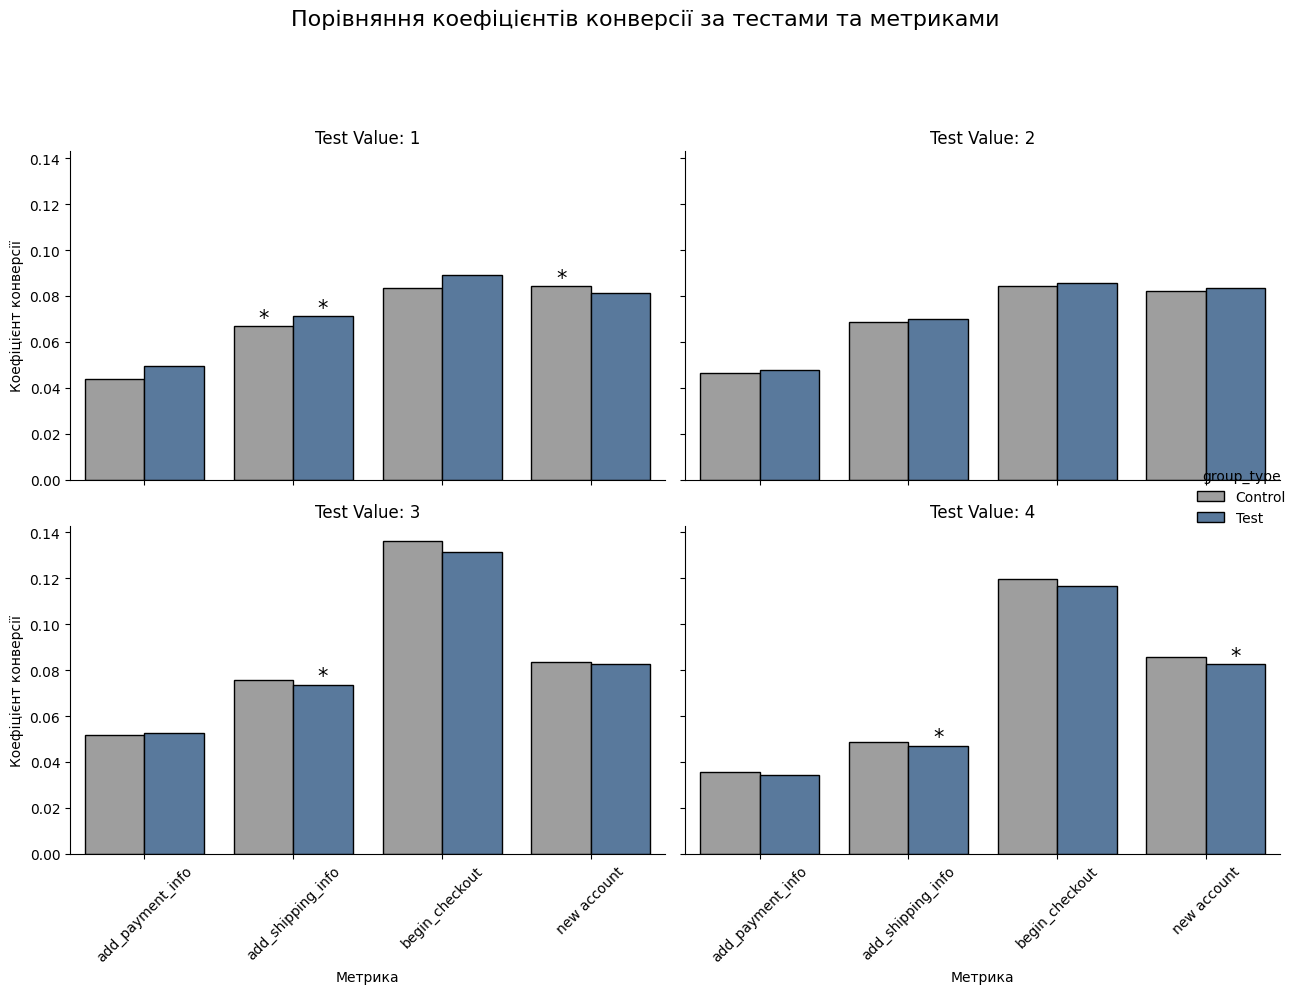

In [97]:
# Prepare data for grouped bar chart
df_plot = final_results_df.melt(id_vars=['test_number', 'metric', 'is_significant'],
                                value_vars=['conversion_rate_control', 'conversion_rate_test'],
                                var_name='group_type',
                                value_name='conversion_rate')

# Map group_type to more readable labels
df_plot['group_type'] = df_plot['group_type'].replace({
    'conversion_rate_control': 'Control',
    'conversion_rate_test': 'Test'
})

# Use seaborn.catplot for faceting
g = sns.catplot(x='metric', y='conversion_rate', hue='group_type',
                col='test_number', data=df_plot,
                kind='bar', # Specify kind='bar' for bar plots
                # palette={'Control': 'skyblue', 'Test': 'lightcoral'},
                palette={'Control': custom_tableau_palette_ab_test[0], 'Test': custom_tableau_palette_ab_test[1]},
                col_wrap=2,
                height=5, aspect=1.2, # Adjust size of individual plots
                edgecolor='black',
                sharey=True # Share y-axis across facets for better comparison
               )

# Add main title to the entire figure
g.fig.suptitle('Порівняння коефіцієнтів конверсії за тестами та метриками', y=1.02, fontsize=16)

# Iterate over each subplot to add significance markers and adjust titles/labels
for i, ax in enumerate(g.axes.flat):
    current_test_value = g.col_names[i] # Get the test_number for the current subplot
    ax.set_title(f'Test Value: {current_test_value}')
    ax.set_xlabel('Метрика')
    ax.set_ylabel('Коефіцієнт конверсії')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(bottom=0)

    # Get unique metrics and group types as they appear in the plot for indexing
    metrics_on_x_axis = df_plot['metric'].unique()

    # Robustly get group_types_in_hue_order, handling cases where g.hue_names might be None
    group_types_in_hue_order = g.hue_names if g.hue_names is not None else df_plot['group_type'].unique().tolist()

    # Iterate through each metric displayed on this subplot's x-axis
    for metric_idx, metric_name in enumerate(metrics_on_x_axis):
        # Check if this metric has a significant result for the current test_number
        significance_row = final_results_df[
            (final_results_df['test_number'] == current_test_value) &
            (final_results_df['metric'] == metric_name)
        ]

        if not significance_row.empty and significance_row['is_significant'].iloc[0] == 'TRUE':
            # Find the 'Test' bar for this metric on the current axis.
            # The bars for a single metric are dodged. 'Control' bar is usually first, then 'Test'.
            # The indices of bars in `ax.patches` for a specific metric_idx are:
            # (metric_idx * len(group_types_in_hue_order)) for 'Control'
            # (metric_idx * len(group_types_in_hue_order)) + 1 for 'Test'

            # Ensure 'Test' is in the group_types for accurate indexing
            if 'Test' in group_types_in_hue_order:
                test_group_idx_in_hue_order = group_types_in_hue_order.index('Test')
                num_hue_groups = len(group_types_in_hue_order)
                test_bar_index = (metric_idx * num_hue_groups) + test_group_idx_in_hue_order

                if test_bar_index < len(ax.patches):
                    test_bar_patch = ax.patches[test_bar_index]
                    if test_bar_patch.get_height() > 0:
                        ax.text(test_bar_patch.get_x() + test_bar_patch.get_width() / 2,
                                test_bar_patch.get_height() + 0.001,
                                '*', ha='center', color='black', fontsize=15)

# Adjust layout
g.fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 2. Візуалізація: Динаміка зміни конверсії (Bar Chart з відсотковою зміною)

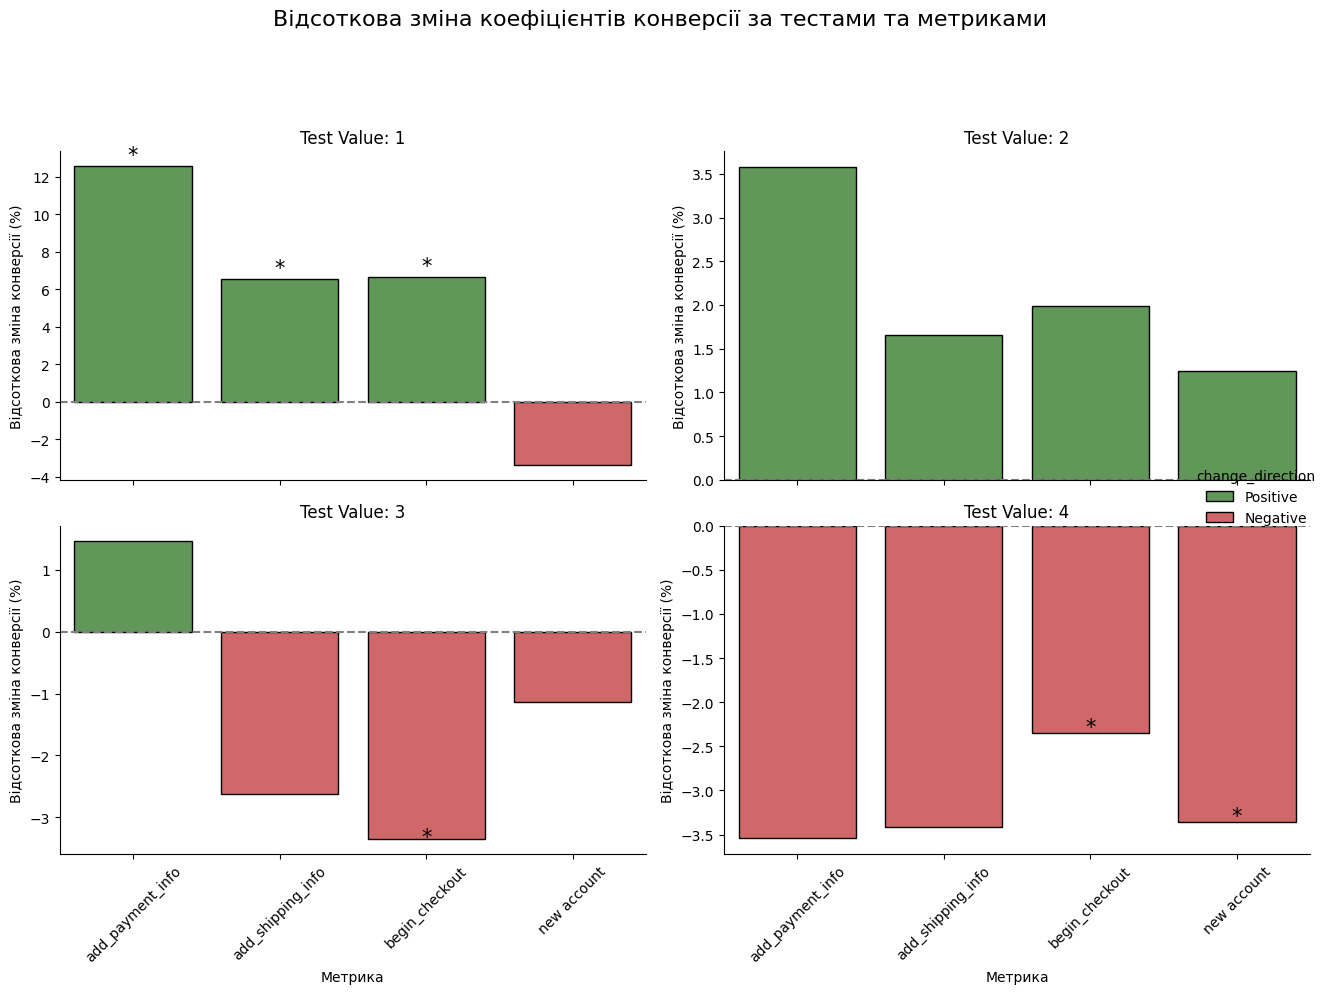

In [98]:
# Calculate the percentage change
final_results_df['percentage_change'] = ((final_results_df['conversion_rate_test'] - final_results_df['conversion_rate_control']) / final_results_df['conversion_rate_control']) * 100

# Create a column for color based on percentage change
final_results_df['change_direction'] = final_results_df['percentage_change'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

# Use seaborn.catplot for faceting
g = sns.catplot(x='metric', y='percentage_change', col='test_number',
                data=final_results_df,
                kind='bar',
                hue='change_direction',
                # palette={'Positive': 'limegreen', 'Negative': 'firebrick'},
                palette={'Positive': custom_tableau_palette_ab_test[2], 'Negative': custom_tableau_palette_ab_test[5]},
                col_wrap=2,
                height=5, aspect=1.2,
                edgecolor='black',
                sharey=False # Do not share y-axis, as percentage changes can vary widely
               )

# Add main title to the entire figure
g.fig.suptitle('Відсоткова зміна коефіцієнтів конверсії за тестами та метриками', y=1.02, fontsize=16)

# Iterate over each subplot to add significance markers and adjust titles/labels
for i, ax in enumerate(g.axes.flat):
    current_test_value = g.col_names[i] # Get the test_value for the current subplot
    ax.set_title(f'Test Value: {current_test_value}')
    ax.set_xlabel('Метрика')
    ax.set_ylabel('Відсоткова зміна конверсії (%)')
    ax.tick_params(axis='x', rotation=45)
    ax.axhline(0, color='grey', linestyle='--') # Add a horizontal line at 0 for reference

    # Iterate through each bar to add significance markers
    for bar_idx, bar in enumerate(ax.patches):
        # Determine which metric this bar corresponds to
        metric_name = final_results_df['metric'].unique()[bar_idx % len(final_results_df['metric'].unique())]

        # Find the significance status for this specific metric and test_value
        significance_status = final_results_df[
            (final_results_df['test_number'] == current_test_value) &
            (final_results_df['metric'] == metric_name)
        ]['is_significant'].iloc[0]

        if significance_status == 'TRUE':
            # Place asterisk above the bar
            bar_height = bar.get_height()
            if bar_height > 0:
                text_y = bar_height + ax.get_ylim()[1] * 0.02 # Slightly above the bar
            else:
                text_y = bar_height - ax.get_ylim()[1] * 0.04 # Slightly below the bar

            ax.text(bar.get_x() + bar.get_width() / 2, text_y,
                    '*', ha='center', color='black', fontsize=15)

# Adjust layout
g.fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 3. Візуалізація: P-Value Heatmap (Теплова карта P-значень)

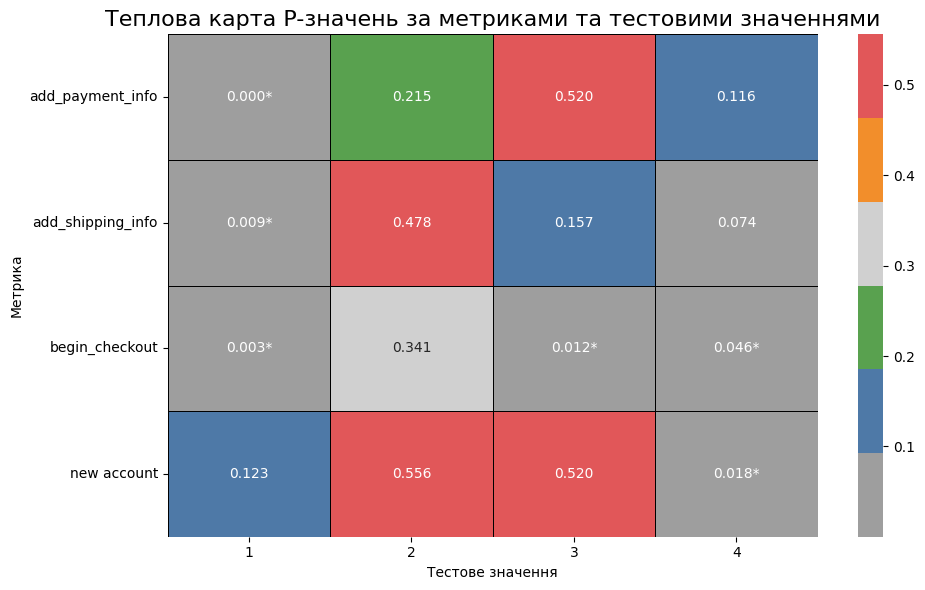

In [99]:
# Pivot the DataFrame for the heatmap
# We want metrics as rows, test_values as columns, and p_values as values
heatmap_data = final_results_df.pivot_table(index='metric', columns='test_number', values='p_value')

color_palette = sns.color_palette(custom_tableau_palette_ab_test, as_cmap=True)
# Create annotation data to show p-values and significance
annotation_data = heatmap_data.map(lambda x: f'{x:.3f}*' if x < alpha else f'{x:.3f}')
# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data,
            annot=annotation_data,
            fmt='',
            # cmap='viridis_r',
            # cmap=custom_tableau_palette_ab_test,
            cmap=color_palette,
            linewidths=.5,
            linecolor='black')

plt.title('Теплова карта P-значень за метриками та тестовими значеннями', fontsize=16)
plt.xlabel('Тестове значення')
plt.ylabel('Метрика')

plt.tight_layout()
plt.show()

### Підготовка даних для створення аналітичного дашборду у Tableau Public.

In [100]:
from google.colab import drive


#### Під'єднаємось до Google Drive та збережемо `csv` файл для подальшої візуалізації у Tableau&

In [101]:
# Make connection & mapping Google Drive for local use
drive.mount("/content/drive")
%pwd
# %ls
%cd /content/drive/MyDrive/MA/Portfolio_project_2
%pwd
# %cd ../
%ls *.csv -AlsF


Mounted at /content/drive
/content/drive/MyDrive/MA/Portfolio_project_2
3 -rw------- 1 root root 2311 Feb 14 09:51 df_ab_test.csv


In [102]:
final_results_df.to_csv('df_ab_test.csv', index=False)
print("DataFrame `final_results_df` збережено у файл `df_ab_test.csv`")

DataFrame `final_results_df` збережено у файл `df_ab_test.csv`


In [103]:
display(final_results_df)

,test_number,metric,numerator_event,denominator_event,numerator_count_test_events,denominator_count_test_sessions,conversion_rate_test,numerator_control_events,denominator_control_sessions,conversion_rate_control,metric_change,z_stat,p_value,is_significant,percentage_change,change_direction
0,1,add_payment_info,add_payment_info,session,2229,45193,0.049322,1988,45362,0.043825,12.542021,3.924884,0.000087,TRUE,12.542021,Positive
1,1,add_shipping_info,add_shipping_info,session,3221,45193,0.071272,3034,45362,0.066884,6.560481,2.603571,0.009226,TRUE,6.560481,Positive
2,1,begin_checkout,begin_checkout,session,4021,45193,0.088974,3784,45362,0.083418,6.660587,2.978783,0.002894,TRUE,6.660587,Positive
3,1,new account,new account,session,3681,45193,0.081451,3823,45362,0.084278,-3.354299,1.542883,0.122859,FALSE,-3.354299,Negative
4,2,add_payment_info,add_payment_info,session,2409,50244,0.047946,2344,50637,0.046290,3.576911,1.240994,0.214608,FALSE,3.576911,Positive
5,2,add_shipping_info,add_shipping_info,session,3510,50244,0.069859,3480,50637,0.068724,1.650995,0.709557,0.477979,FALSE,1.650995,Positive
6,2,begin_checkout,begin_checkout,session,4313,50244,0.085841,4262,50637,0.084168,1.988164,0.952898,0.340642,FALSE,1.988164,Positive
7,2,new account,new account,session,4184,50244,0.083274,4165,50637,0.082252,1.241934,0.588793,0.556000,FALSE,1.241934,Positive
8,3,add_payment_info,add_payment_info,session,3697,70439,0.052485,3623,70047,0.051722,1.474630,0.643172,0.520112,FALSE,1.474630,Positive
9,3,add_shipping_info,add_shipping_info,session,5188,70439,0.073652,5298,70047,0.075635,-2.621211,1.413727,0.157442,FALSE,-2.621211,Negative


## Етап 2. Візуалізації у Tableau



#### 1️⃣ Funnel-style visualization (Conversion by step)

Що показує:
- Як тест впливає на етапи воронки.

> Особливості:
- Додано label з % різницею (`test_conversion` - `control_conversion`).
Це одразу відповідає на питання: *де тест виграв*.
  

> Інтерпретація:
  Показує на якому саме кроці тест дає або вбиває ефект.

#### 2️⃣ Bar Chart: Control vs Test Conversion по метриках

Що показує:
  - Порівняння control_conversion vs test_conversion для кожної metric, розбивка по test_value.

Особливості:
  - Навіть якщо це не класичний funnel, Tableau добре “презентує” таку логіку в презентаціях.

Інтерпретація:
> Швидкий бізнес-висновок: *які кроки воронки реально покращились*.

#### 3️⃣ Heatmap: Significance Matrix

Що показує:
- Де результати статистично значущі, а де ні.

Особливості:
- Колірна шкала:
  - зелений → значущий ефект
  - сірий → незначущий

> Інтерпретація:

  * Ідеально для аналітичного рев’ю:
“*Окей, де ми реально можемо щось впроваджувати?*”

#### 4️⃣  Bar Chart: Is Significant Control vs  Test Conversion by Metric

Що показує:
  - Порівняння control_conversion vs test_conversion для кожної metric, розбивка по test_value.
  - Індикація Is Significant.

Особливості:
  - Навіть якщо це не класичний funnel, Tableau добре “презентує” таку логіку в презентаціях.

Інтерпретація:
> Швидкий бізнес-висновок: *які кроки воронки реально покращились та результат є значущим*.

#### Посилання на візуалізацію: [аналітичний дашборд у Tableau Public](https://public.tableau.com/views/AB_Test_Project_Key_Conversion/ABtesting-keyconversionmetrics?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

### Insights or Next Steps
*   The corrected visualizations provide a clear and accurate representation of the A/B test results, including percentage changes in conversion rates and statistical significance.
*   Proceed with analyzing the generated plots to derive business insights from the A/B test outcomes for different metrics and test groups.
